In [ ]:
pip install matplotlib 

In [2]:
import pandas as pd
import numpy as np
from binance.client import Client
from ta.volatility import BollingerBands

In [134]:
client = Client()
symbol = 'BTCUSDT'
df = client.get_historical_klines(symbol=symbol, interval='1h', start_str='Aug, 01 2023')
df = pd.DataFrame(df)
df = df.iloc[:, :6]
df.columns = ["datetime", "open", "high", "low", "close", "volume"]
df['open'] = df['open'].astype('float')
df['high'] = df['high'].astype('float')
df['low'] = df['low'].astype('float')
df['close'] = df['close'].astype('float')
df['volume'] = df['volume'].astype('float')
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms') - pd.Timedelta('3 hr')
df=df.set_index('datetime')

In [150]:
class Strategy:
    def signal(self,df):
        

        df['emaL'] = df['low'].ewm(span=2, adjust=True).mean()
        df['emaH'] = df['high'].ewm(span=2, adjust=True).mean()
        
        BB = BollingerBands(df['close'], window=20,window_dev=3, fillna=True)
        df['bbh'] = BB._hband
        df['bbl'] = BB._lband
        #df['bbm'] = BB._mavg #BB media
        df['bba'] = (BB._mstd/df['close'])*100 #Desvio estandard porcentual sobre el precio
        df['bba_m'] = df['bba'].rolling(window=10).mean()

        # Calcular polyfit para las últimas 10 y 20 observaciones usando rolling y apply
        df['trend'] = (df['close'].rolling(window=20).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=False)/df['close'])*100
        df['trend_m'] = df['trend'].rolling(window=10).mean()

        df['zero'] = 0.0
        
        df['compra'] = (df['trend']<0.15) & (df['bba']>1.0) & (df['bba'] < df['bba_m']) & (df['bba'].shift(1) > df['bba_m'].shift(1))
        df['venta']  = (df['trend']>0.15) & (df['bba']>1.0) & (df['bba'] < df['bba_m']) & (df['bba'].shift(1) > df['bba_m'].shift(1))

        df['signal'] = np.where(df['compra'], 'COMPRA', 'NEUTRO')
        df['signal'] = np.where(df['venta'], 'VENTA',df['signal'])

        df['buy_price']  = np.where(df['compra'],df['close'],None)
        df['sell_price'] = np.where(df['venta'],df['close'],None)


        return df

<Axes: xlabel='datetime'>

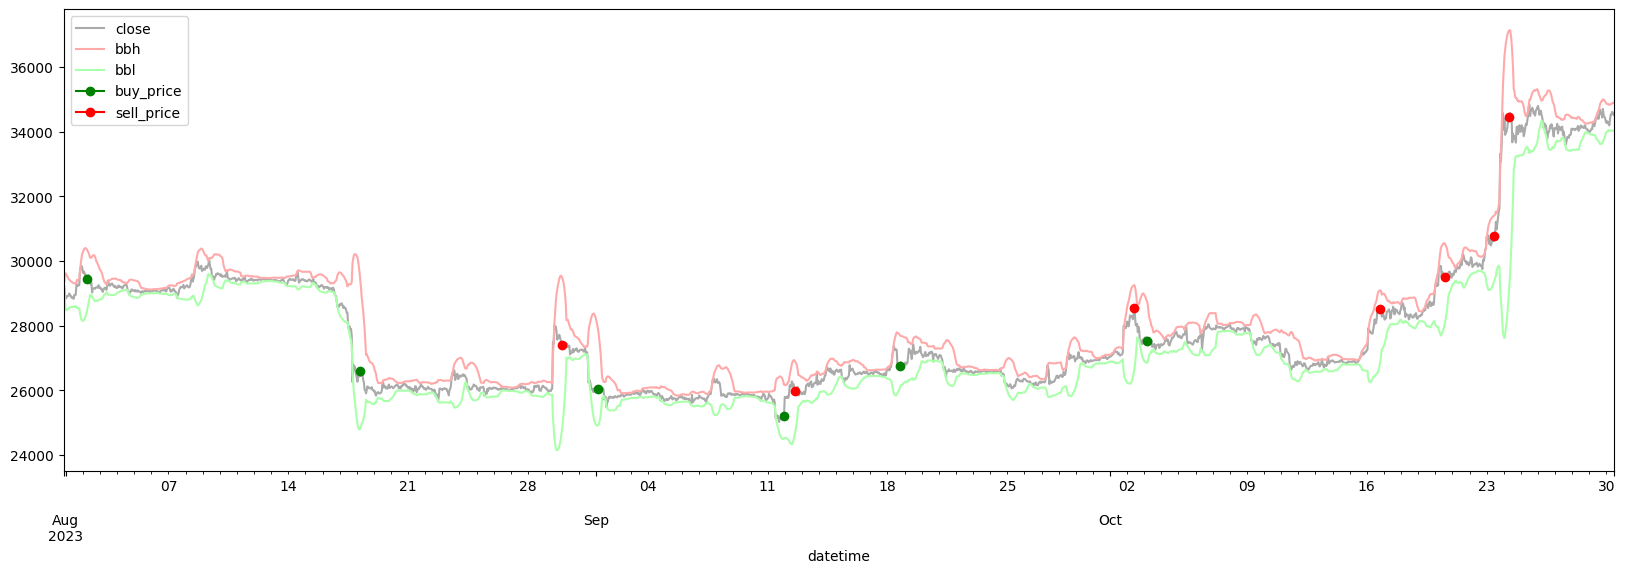

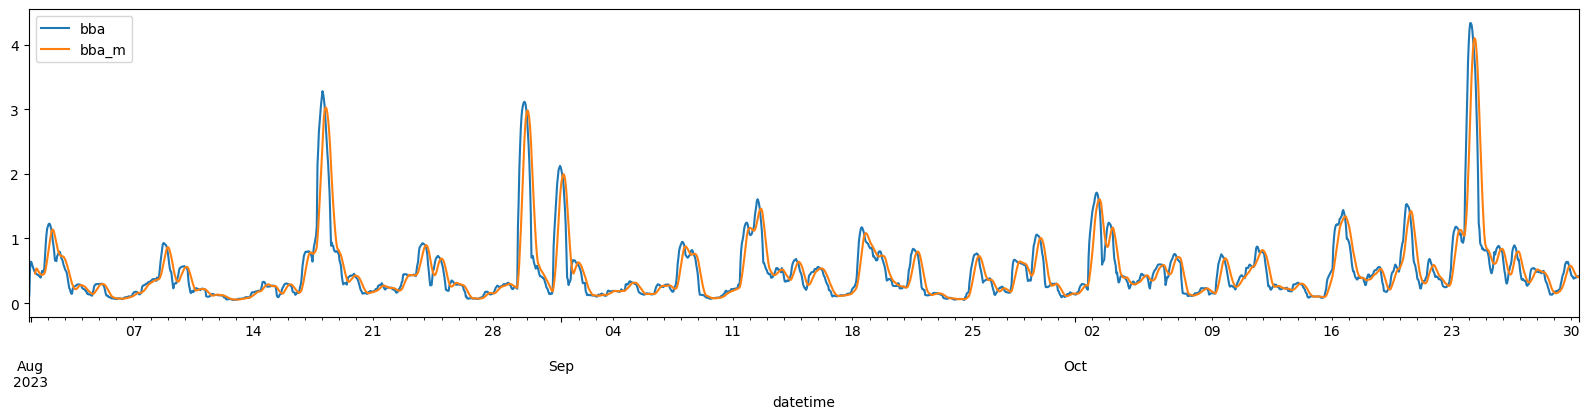

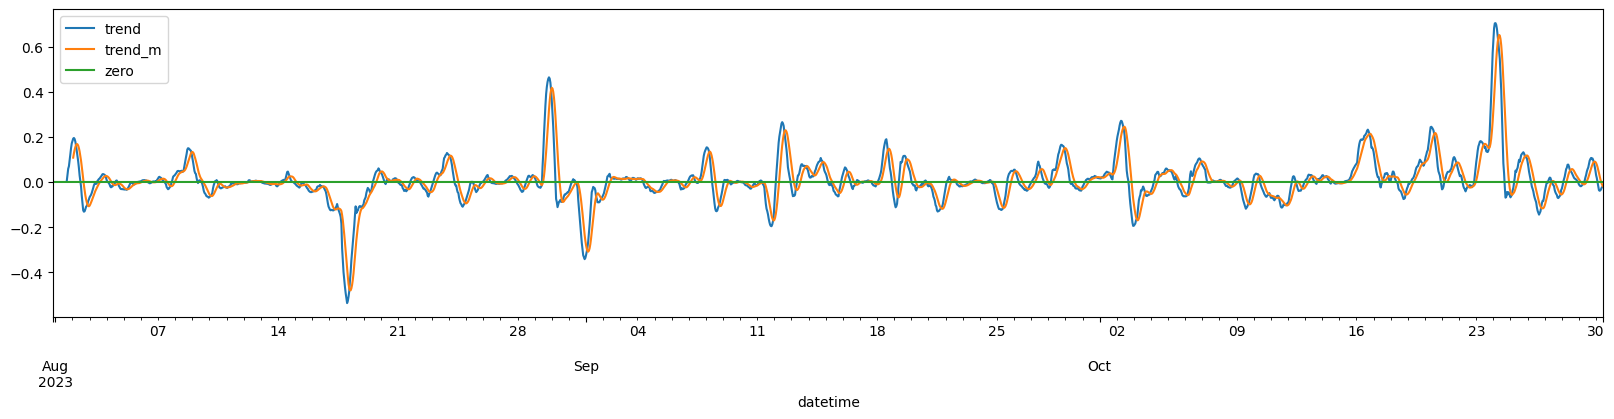

In [151]:

# Aplicar la función signal
df = Strategy().signal(df)

df[['close','bbh','bbl','buy_price','sell_price']].plot(figsize=(20,6),style=['#aaaaaa','#ffaaaa','#aaffaa','g-o','r-o'])
df[['bba','bba_m']].plot(figsize=(20,4))
df[['trend','trend_m','zero']].plot(figsize=(20,4))

#df[['ema','bbh','bbl']].head(20)
